In [1]:
import typing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import QuantLib as ql
import yfinance as yf
import pandas_market_calendars as mcal
import datetime
import time
from pathlib import Path
import os

# Self-written modules
from yq.scripts import models
from yq.scripts import heston_func
from yq.utils import option
from yq.utils import calendar
from yq.scripts import simulation as sm
from sc import constants as cs
from sy.variance_reduction import apply_control_variates, apply_empirical_martingale_correction
from sy.interest_rate import populate_bond_table, get_period
from sc import payoff as po

In [7]:
print(cs.ASSET_NAMES)

['LONN.SE', 'SIKA.SE']


# Fetch stock data

[*********************100%%**********************]  2 of 2 completed


,LONN.SE,SIKA.SE
Date,,
2023-10-23,327.600006,215.899994
2023-10-24,330.899994,215.699997
2023-10-25,315.000000,212.000000
2023-10-26,315.899994,211.199997
2023-10-27,314.600006,214.100006
2023-10-30,311.500000,214.100006
2023-10-31,316.799988,216.899994
2023-11-01,318.600006,215.199997
2023-11-02,320.000000,223.800003


331.3999938964844

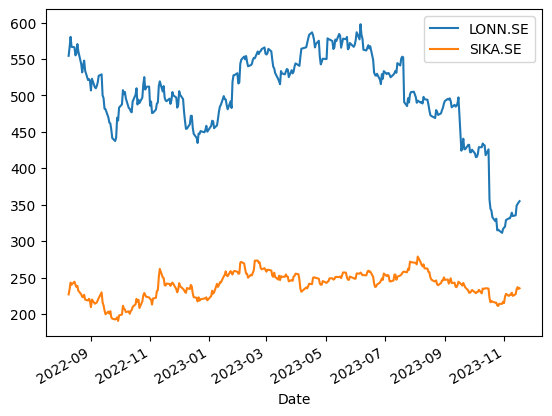

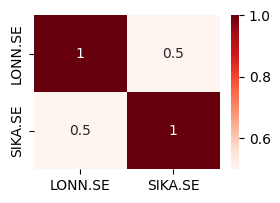

In [2]:
historical_start_date = '2022-08-09'
# Define the ticker list
ticker_list = ['LONN.SW', 'SIKA.SW']

# Fetch the data
data = yf.download(ticker_list, historical_start_date)['Adj Close'] # Auto adjust is false
data = data.rename(columns={'LONN.SW': 'LONN.SE', 'SIKA.SW': 'SIKA.SE'})
data.index = pd.to_datetime(data.index)
display(data.tail(20))
data.plot()
display(data.loc['2023-11-07']['LONN.SE'])

plt.figure(figsize=(3,2))
sns.heatmap(data.corr(), cmap="Reds", annot=True)
plt.show()

In [3]:
params = {
    'data': data,
    'ticker_list': ['LONN.SW', 'SIKA.SW']
}
trading_calendar = calendar.SIXTradingCalendar()
gbm = models.PricingModel(params = params)

### Test out get sim_data list

In [ ]:
# Copy the start_time_str from the folders
product_est_date_sim_data_df_list = sm.read_sim_data(
        model_name='gbm',
        start_time_str='20231111_185351_394318', 
        prod_est_start_date=pd.Timestamp('2023-08-09'), 
        prod_est_end_date=pd.Timestamp('2023-08-10'))
print(type(product_est_date_sim_data_df_list)[0])
n_sim_on_day = pd.concat(product_est_date_sim_data_df_list[0], axis=1)
ax = n_sim_on_day.plot(alpha=0.6, legend=False)
ax.figure.show()


In [ ]:
product_est_date_sim_data_df_list[0]


# Testing diff h (stale, refer to normal sims while creating class)

In [ ]:
bus_date_range = trading_calendar.create_six_trading_dates('2023-08-09', '2023-08-09')
# display(bus_date_range)
# print(bus_date_range.index.to_list())
start_time_acc = datetime.datetime.now() # Track the nth attempt
print(start_time_acc)
n_sim = 1
for product_est_date in bus_date_range.index:
    try:
        start_time = time.time()

        sim_data_df = []
        for sim in range(n_sim):
            sim_start_date = trading_calendar.add_trading_day(product_est_date, 1)
            
            sim_data = gbm.multi_asset_gbm(
                sim_start_date=sim_start_date, 
                hist_window=252, 
                sim_window=trading_calendar.calculate_business_days(sim_start_date, cs.FINAL_FIXING_DATE), 
                h_adjustment=[0, 0])

            sim_data_h = gbm.multi_asset_gbm(
                sim_start_date=sim_start_date, 
                hist_window=252, 
                sim_window=trading_calendar.calculate_business_days(sim_start_date, cs.FINAL_FIXING_DATE), 
                h_adjustment=[1000, 0])
        end_time = time.time()
        elapsed_time = end_time - start_time
        min, sec = divmod(elapsed_time, 60)
        print(f"The elapsed time is for {n_sim} is {int(min)} minutes, {int(sec)} seconds")
        
        S_T_1 = sim_data.loc[cs.FINAL_FIXING_DATE, 'LONN.SW']
        S_T_2 = sim_data_h.loc[cs.FINAL_FIXING_DATE,'LONN.SW']
        print(S_T_1 / S_T_2)
        
    except Exception as e:
        # Log the error with the date that caused it
        raise Exception("MultiGBM has error.")


In [ ]:
print(489/1489)


In [11]:
params = {
    'data': data.rename(columns={'LONN.SE': 'LONN.SW', 'SIKA.SE': 'SIKA.SW'}),
    'ticker_list': ['LONN.SW', 'SIKA.SW']
    
}
trading_calendar = calendar.SIXTradingCalendar()
heston = models.PricingModel(params = params)

In [12]:
bus_date_range = trading_calendar.create_six_trading_dates('2023-11-06', '2023-11-06')
# display(bus_date_range)
# print(bus_date_range.index.to_list())
start_time_acc = datetime.datetime.now() # Track the nth attempt
print(start_time_acc)
n_sim = 1
for product_est_date in bus_date_range.index:
    try:
        start_time = time.time()

        sim_data_df = []
        for sim in range(n_sim):
            sim_start_date = trading_calendar.add_trading_day(product_est_date, 1)
            
            sim_data = heston.multi_asset_heston_model(
                sim_start_date=sim_start_date, 
                hist_window=252, 
                sim_window=trading_calendar.calculate_business_days(sim_start_date, cs.FINAL_FIXING_DATE), 
                h_adjustment=[0, 0])

            # sim_data_h = heston.multi_asset_heston_model(
            #     sim_start_date=sim_start_date, 
            #     hist_window=252, 
            #     sim_window=trading_calendar.calculate_business_days(sim_start_date, cs.FINAL_FIXING_DATE), 
            #     h_adjustment=[1, 0])
        end_time = time.time()
        elapsed_time = end_time - start_time
        min, sec = divmod(elapsed_time, 60)
        print(f"The elapsed time is for {n_sim} is {int(min)} minutes, {int(sec)} seconds")
        
        # S_T_1 = sim_data.loc[cs.FINAL_FIXING_DATE, 'LONN.SW']
        # S_T_2 = sim_data_h.loc[cs.FINAL_FIXING_DATE,'LONN.SW']
        # print(S_T_1 / S_T_2)
        
    except Exception as e:
        # Log the error with the date that caused it
        raise Exception("MultiHeston has error.")


2023-11-18 12:36:07.173166
S_0_vector is [331.3999938964844, 225.0]

/Users/tangyiqwan/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Acads/4_Y4S1/MH4518/group-project/code/simulation-in-finance
/Users/tangyiqwan/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Acads/4_Y4S1/MH4518/group-project/code/simulation-in-finance/data/options/lonn_call.csv
Lonza options:
     maturity strike      price    rate
0    0.028070    310  23.025003  0.0175
1    0.028070    315  18.525003  0.0175
2    0.028070    320  14.450001  0.0175
3    0.028070    325  10.825001  0.0175
4    0.028070    330   7.675001  0.0175
..        ...    ...        ...     ...
115  0.892632    360  25.174999  0.0175
116  0.892632    380  18.825001  0.0175
117  0.892632    400  13.925000  0.0175
118  0.892632    410  11.950001  0.0175
119  0.892632    420  10.200001  0.0175

[120 rows x 4 columns]
/Users/tangyiqwan/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Acads/4_Y4S1/M

Exception: MultiHeston has error.

In [ ]:
489/490


In [ ]:
display(sim_data)
display(sim_data_h)

In [ ]:
print(355/1404.907)

In [ ]:
0.32840832773673606

# Normal sims 

In [ ]:
trading_calendar = calendar.SIXTradingCalendar()
bus_date_range = trading_calendar.create_six_trading_dates('2023-08-09', '2023-11-09')
# display(bus_date_range)
# print(bus_date_range.index.to_list())
start_time_acc = datetime.datetime.now() # Track the nth attempt
print(start_time_acc)
n_sim = 100


for product_est_date in bus_date_range.index:
    try:
        start_time = time.time()
        params = {
            'data': data,
            'ticker_list': ['LONN.SW', 'SIKA.SW']
        }
        sim_data_df = []
        gbm = models.PricingModel(params=params)
        for sim in range(n_sim):
            sim_start_date = trading_calendar.add_trading_day(product_est_date, 1)
            
            sim_data = gbm.multi_asset_gbm(
                sim_start_date=sim_start_date, 
                hist_window=252, 
                sim_window=trading_calendar.calculate_business_days(sim_start_date, cs.FINAL_FIXING_DATE), 
                h_adjustment=[0, 0])
            sim_data_df.append(sim_data)
            
            sm.store_sim_data(uid='20231110_222722_149946',
                           model_name='gbm',
                           sim_data=sim_data,
                           product_est_date=product_est_date,
                           sim=sim)

        end_time = time.time()
        elapsed_time = end_time - start_time
        min, sec = divmod(elapsed_time, 60)
        print(f"The elapsed time is for {n_sim} is {int(min)} minutes, {int(sec)} seconds")
        
    except Exception as e:
        # Log the error with the date that caused it
        raise Exception("MultiGBM has error.")
    
    
    # TODO: Tag the sim_data with the dates
    # TODO: Add the concate the yfinance data from initial fixing date to the sim_data
    # TODO: Break the df into 2 df, each with date as one of the columns (not the index) for sc payoff function
    # Get the data?

    
    # TODO: Store the payoff df to the class and plot?

# TODO: Implement the second simulation with the control variate method? Another loop or same loop?

# sim_data.columns = ["simulated_" + ticker for ticker in ticker_list]

# A dataframe with both validation data and simulated data


In [10]:
# generate bond table
path = '../data/bond'

bond_yield = None
for file in os.listdir(path):
   df = pd.read_csv(os.path.join(path, file))[['Date','Price']]
   df.rename(columns={'Price':file.split(' ')[1]}, inplace=True)
   df['Date'] = pd.to_datetime(df['Date'],format='%m/%d/%Y')
   df = df.set_index('Date').iloc[::-1]
   if bond_yield is None:
      bond_yield = df
   else:
      bond_yield = pd.concat([bond_yield, df], axis=1)
bond_yield = bond_yield.interpolate()
bond_yield = bond_yield.reindex(sorted(bond_yield.columns, key=lambda x: get_period(x)), axis=1) # sort index
bond_price = pd.DataFrame(index=bond_yield.index)
for col in bond_yield.columns:
    bond_price[col] = bond_yield[col].apply(lambda x: np.exp(-x/100*get_period(col)))
bond_price

,1-Week,1-Month,2-Month,3-Month,6-Month,1-Year,2-Year
Date,,,,,,,
2022-01-01,1.000192,1.000667,1.001301,1.002378,1.004510,1.008032,NaN
2022-01-02,1.000192,1.000642,1.001267,1.002253,1.004259,1.008032,NaN
2022-01-03,1.000169,1.000700,1.001451,1.002152,1.004259,1.008032,1.014098
2022-01-04,1.000173,1.000717,1.001234,1.002152,1.004259,1.007327,1.014687
2022-01-05,1.000181,1.000725,1.001334,1.002177,1.004259,1.007327,1.014403
...,...,...,...,...,...,...,...
2023-11-06,0.999696,0.998676,0.997270,0.995983,0.991784,0.983439,0.973829
2023-11-07,0.999696,0.998676,0.997287,0.995983,0.991784,0.983439,0.973595
2023-11-08,0.999696,0.998676,0.997470,0.995983,0.991784,0.983439,0.974062


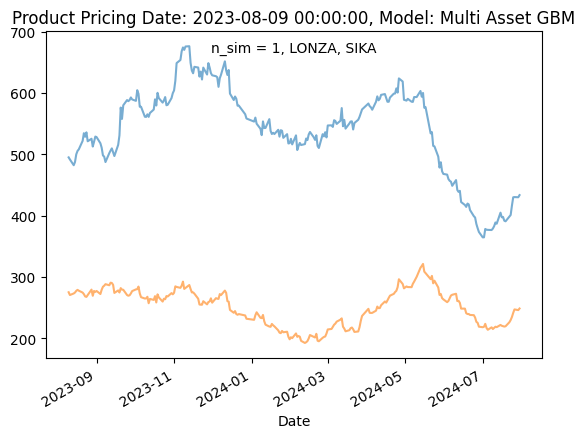

In [11]:
from yq.scripts import simulation as yqsm

# for product_est_date in bus_date_range.index:
#     try:
#         start_time = time.time()
#         params = {
#             'data': data,
#             'ticker_list': ['LONN.SW', 'SIKA.SW']
#         }
#         sim_data_df = []
#         gbm = models.PricingModel(params=params)
#         for sim in range(n_sim):
#             sim_start_date = trading_calendar.add_trading_day(product_est_date, 1)
            
#             sim_data = gbm.multi_asset_gbm(
#                 sim_start_date=sim_start_date, 
#                 hist_window=252, 
#                 sim_window=trading_calendar.calculate_business_days(sim_start_date, cs.FINAL_FIXING_DATE), 
#                 h_adjustment=[0, 0])
#             sim_data_df.append(sim_data)
            
#             sm.store_sim_data(start_time_acc=start_time_acc,
#                            model_name='gbm',
#                            sim_data=sim_data,
#                            product_est_date=product_est_date,
#                            sim=sim)

        
#         print(f"The elapsed time is for {n_sim} is {int(min)} minutes, {int(sec)} seconds")
        
#     except Exception as e:
#         # Log the error with the date that caused it
#         raise Exception("MultiGBM has error.")
    
    
    # TODO: Tag the sim_data with the dates
    # TODO: Add the concate the yfinance data from initial fixing date to the sim_data
    # TODO: Break the df into 2 df, each with date as one of the columns (not the index) for sc payoff function
    # Get the data?

    
    # TODO: Store the payoff df to the class and plot?

# TODO: Implement the second simulation with the control variate method? Another loop or same loop?
start = pd.Timestamp('2023-08-09')
end = pd.Timestamp('2023-11-09')

product_est_date_sim_data_df_list = yqsm.read_sim_data('gbm/archive', '20231111_195045_022812', start, end)
for product_est_date_sim_data_df in product_est_date_sim_data_df_list:
    for i in range(len(product_est_date_sim_data_df)):
        product_est_date_sim_data_df[i] = product_est_date_sim_data_df[i].rename(columns = {'LONN.SW': 'LONN.SE', 'SIKA.SW': 'SIKA.SE'})
sim = product_est_date_sim_data_df_list[0][0]
ax = sim.plot(alpha=0.6, legend=False)
ax.set_title(f"Product Pricing Date: {start}, Model: Multi Asset GBM")
ax.text(0.5, 0.95, f"n_sim = 1, LONZA, SIKA", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.show()

In [12]:
sim

,LONN.SE,SIKA.SE
Date,,
2023-08-10,495.071653,275.078187
2023-08-11,491.667070,270.557708
2023-08-14,482.259156,273.067201
2023-08-15,487.483163,274.634728
2023-08-16,500.038604,277.364954
...,...,...
2024-07-24,416.334894,234.760395
2024-07-25,429.965714,241.369146
2024-07-26,430.300003,247.062289


In [54]:
sim_interest_adjusted = gbm.adjust_interest_rate(bond_price, sim)

,LONN.SE,SIKA.SE
Date,,
2023-08-10,495.037274,275.059085
2023-08-11,491.632928,270.538920
2023-08-14,482.225667,273.048239
2023-08-15,487.449312,274.615657
2023-08-16,500.003880,277.345693
...,...,...
2024-07-24,416.330386,234.757853
2024-07-25,429.961059,241.366532
2024-07-26,430.295346,247.059615


In [83]:
sim = sim.rename(columns={'LONN.SE (MC)': 'LONN.SE (const. r)','SIKA.SE (MC)': 'SIKA.SE (const. r)'})

<Axes: title={'center': 'Constant r vs. Deterministic r'}, xlabel='Date'>

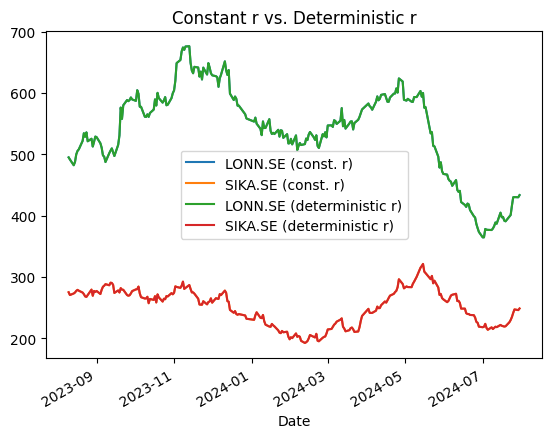

In [84]:
sim_interest_adjusted = sim_interest_adjusted.rename(columns = {'LONN.SE (Adjusted)': 'LONN.SE (deterministic r)', 'SIKA.SE (Adjusted)': 'SIKA.SE (deterministic r)'})
pd.concat([sim,sim_interest_adjusted],axis=1).plot(title='Constant r vs. Deterministic r')

In [85]:
print(sim)
print(sim_interest_adjusted)

            LONN.SE (const. r)  SIKA.SE (const. r)
Date                                              
2023-08-10          495.071653          275.078187
2023-08-11          491.667070          270.557708
2023-08-14          482.259156          273.067201
2023-08-15          487.483163          274.634728
2023-08-16          500.038604          277.364954
...                        ...                 ...
2024-07-24          416.334894          234.760395
2024-07-25          429.965714          241.369146
2024-07-26          430.300003          247.062289
2024-07-29          430.034470          245.947811
2024-07-30          433.517181          248.589679

[244 rows x 2 columns]
            LONN.SE (deterministic r)  SIKA.SE (deterministic r)
Date                                                            
2023-08-10                 495.037274                 275.059085
2023-08-11                 491.632928                 270.538920
2023-08-14                 482.225667                

In [87]:
((sim['LONN.SE (const. r)'] - sim_interest_adjusted['LONN.SE (deterministic r)']).mean()+ (sim['SIKA.SE (const. r)'] - sim_interest_adjusted['SIKA.SE (deterministic r)']).mean())/2

0.006954316393486157

time difference is 84.0


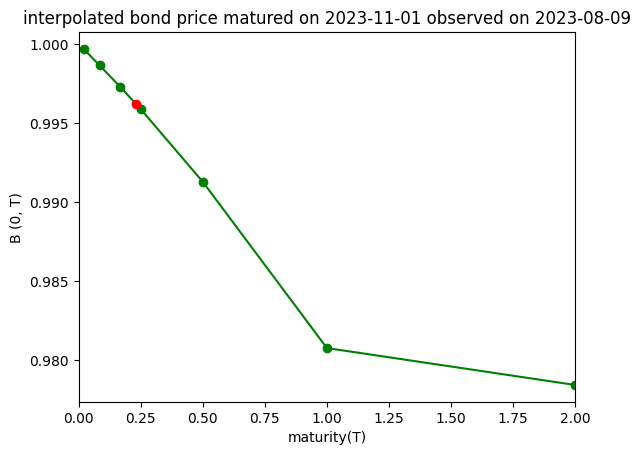

In [15]:
today = pd.Timestamp('2023-08-09')
date = pd.Timestamp('2023-11-01')

X = [get_period(col) for col in bond_price.columns]
Y = bond_price.loc[today].to_list()
tdelta = (date - today).days/365
print(f'time difference is {tdelta*365}')
interpolated_y = np.interp(tdelta,X,Y)
plt.xlim((0,2))
plt.xlabel('maturity(T)')
plt.ylabel('B (0, T)')
plt.title('interpolated bond price matured on {} observed on {}'.format(date.strftime('%Y-%m-%d'), today.strftime('%Y-%m-%d')))
plt.plot(X, Y, "og-", tdelta, interpolated_y, "or")

In [16]:
# Variance reduction
today = pd.Timestamp('2023-08-09')

# calculate means
s_01  = data.loc[today]['LONN.SE']
s_02 =  data.loc[today]['SIKA.SE']
bond_table = populate_bond_table(bond_price, today, cs.REDEMPTION_DATE)
mu1 = s_01 * bond_table.loc[today]['price']
mu2 = s_02 * bond_table.loc[today]['price']
print(mu1, mu2)


488.8542621062459 265.4208723705691


In [17]:
sim_arr = product_est_date_sim_data_df_list[0]
S1T_n = []
S2T_n = []
for i in range(len(sim_arr)):
    sim_arr[i] = sim_arr[i].rename(columns={'LONN.SW': 'LONN.SE', 'SIKA.SW': 'SIKA.SE'})
    ST = sim_arr[i].iloc[-1,:]
    S1T_n.append(ST[cs.ASSET_NAMES[0]])
    S2T_n.append(ST[cs.ASSET_NAMES[1]])
payoffs = po.pricing_multiple(sim_arr)

In [18]:
payoffs_cv = apply_control_variates(S1T_n, S2T_n, mu1, mu2, payoffs)
payoffs_cv.var()

19764.441628612058

In [19]:
payoff = np.array(payoffs[50:])
payoff.var()

31046.841173460587

In [20]:
ptg_change = (payoff.var() - payoffs_cv.var())/payoff.var()
ptg_change

0.36339927407793526

In [26]:
first_date = pd.Timestamp('2023-08-09')
last_date = pd.Timestamp('2023-11-09')

#load simulated paths from csvs
total_data = yqsm.read_sim_data('gbm/archive', '20231111_195045_022812', first_date, last_date)
for product_est_date_sim_data_df in total_data:
    for i in range(len(product_est_date_sim_data_df)):
        product_est_date_sim_data_df[i] = product_est_date_sim_data_df[i].rename(columns = {'LONN.SW': 'LONN.SE', 'SIKA.SW': 'SIKA.SE'})

n_sim = 100
ratio = 0.5
est_price_MC, est_price_CV, est_price_EMC, est_price_CV_EMC = [], [], [], []
est_price_MC_var, est_price_CV_var = [], []
bus_date_range = trading_calendar.create_six_trading_dates('2023-08-09', '2023-11-09')
for i, product_est_date in enumerate(bus_date_range.index):
    single_day_sim_arr = total_data[i]
    split = int(ratio*n_sim)
    if i == 0: today = product_est_date - datetime.timedelta(days=1)
    else: today = bus_date_range.index[i-1]
    single_day_sim_arr_EMC = apply_empirical_martingale_correction(data, single_day_sim_arr, today)
    prices = po.pricing_multiple(single_day_sim_arr)
    prices_EMC = po.pricing_multiple(single_day_sim_arr_EMC)
    est_price_EMC.append(sum(prices_EMC[split:])/ len(prices_EMC[split:]))
    est_price_MC.append(sum(prices[split:]) / len(prices[split:]))
    est_price_MC_var.append(np.array(prices[split:]).var())
    S1T_n, S2T_n = [], []
    for j in range(len(single_day_sim_arr)):
        ST = single_day_sim_arr[j].iloc[-1,:]
        S1T_n.append(ST[cs.ASSET_NAMES[0]])
        S2T_n.append(ST[cs.ASSET_NAMES[1]])
    s_01  = data.loc[today][cs.ASSET_NAMES[0]]
    s_02 =  data.loc[today][cs.ASSET_NAMES[1]]
    bond_table = populate_bond_table(bond_price, today, cs.REDEMPTION_DATE)
    mu1 = s_01 * bond_table.loc[today]['price']
    mu2 = s_02 * bond_table.loc[today]['price']
    prices_CV = apply_control_variates(S1T_n, S2T_n, mu1, mu2, prices)
    prices_CV_EMC = apply_control_variates(S1T_n, S2T_n, mu1, mu2, prices_EMC)
    est_price_CV.append(sum(prices_CV)/len(prices_CV))
    est_price_CV_EMC.append(sum(prices_CV_EMC)/len(prices_CV_EMC))
    est_price_CV_var.append(np.array(prices_CV).var())


/opt/homebrew/lib/python3.11/site-packages/matplotlib/axis.py:1769: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  ret = self.converter.convert(x, self.units, self)
/opt/homebrew/lib/python3.11/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/opt/homebrew/lib/python3.11/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/opt/homebrew/lib/python3.11/site-packages/matplotlib/axis.py:1769: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ret = self.converter.convert(x, self.units, self)
/op

<Axes: xlabel='Date'>

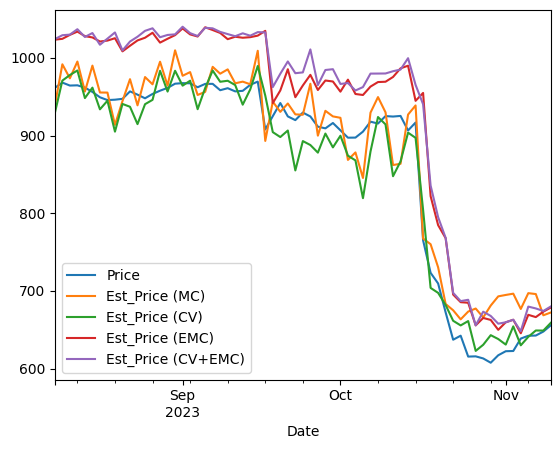

In [27]:
df_product = po.get_product_price(pd.Timestamp('2023-11-09'))
df_product = df_product.loc[first_date : last_date]
df_product['Est_Price (MC)'] = est_price_MC
df_product['Est_Price (CV)'] = est_price_CV
df_product['Est_Price (EMC)'] = est_price_EMC
df_product['Est_Price (CV+EMC)'] = est_price_CV_EMC
df_product.plot()

In [88]:
rmse_MC = np.sqrt(np.mean(df_product['Est_Price (MC)']-df_product['Price'])**2)
rmse_CV = np.sqrt(np.mean(df_product['Est_Price (CV)']-df_product['Price'])**2)
rmse_EMC = np.sqrt(np.mean(df_product['Est_Price (EMC)']-df_product['Price'])**2)
rmse_CV_EMC = np.sqrt(np.mean(df_product['Est_Price (CV+EMC)']-df_product['Price'])**2)

In [90]:
rmse_MC, rmse_CV, rmse_EMC, rmse_CV_EMC

(15.569391610500144, 6.957790011388192, 59.33200957462317, 65.45769756852775)

In [91]:
mae_MC = np.mean(np.abs(df_product['Est_Price (MC)'] - df_product['Price']))
mae_CV = np.mean(np.abs(df_product['Est_Price (CV)'] - df_product['Price']))
mae_EMC = np.mean(np.abs(df_product['Est_Price (EMC)'] - df_product['Price']))
mae_CV_EMC = np.mean(np.abs(df_product['Est_Price (CV+EMC)'] - df_product['Price']))

In [92]:
mae_MC, mae_CV, mae_EMC, mae_CV_EMC

(26.584129394953212, 20.938286839312166, 59.33200957462317, 65.45769756852775)

In [23]:
price_var_df = pd.DataFrame({'Variance (MC)': est_price_MC_var, 'Variance (CV)': est_price_CV_var})
price_var_df['Pct Change (%)'] = price_var_df.pct_change(axis=1)['Variance (CV)']*100
price_var_df

,Variance (MC),Variance (CV),Pct Change (%)
0,31046.841173,19764.441629,-36.339927
1,18127.252768,14043.723205,-22.527018
2,22615.033007,23057.968787,1.958590
3,14192.235210,10951.851432,-22.832089
4,25494.706609,16542.998401,-35.112027
...,...,...,...
62,30159.513307,4439.775159,-85.279023
63,37734.579014,6387.050533,-83.073746
64,24091.656204,329.213694,-98.633495
65,22379.998608,1623.838381,-92.744243


In [25]:
print("average variance: ", price_var_df.mean())
print("average variance reduced: ", (price_var_df['Pct Change (%)']*-1).mean())

average variance:  Variance (MC)     31532.039962
Variance (CV)     16347.240756
Pct Change (%)      -45.199014
dtype: float64
average variance reduced:  45.19901409281829


In [52]:
today = pd.Timestamp('2023-08-09')
sim_arr_EMC = apply_empirical_martingale_correction(data, sim_arr, today)
colnames = sim_arr_EMC[0].columns
colnames = {col: col + ' (EMC)' for col in colnames}
for i in range(len(sim_arr_EMC)):
    sim_arr_EMC[i] = sim_arr_EMC[i].rename(columns=colnames)

<Axes: xlabel='Date'>

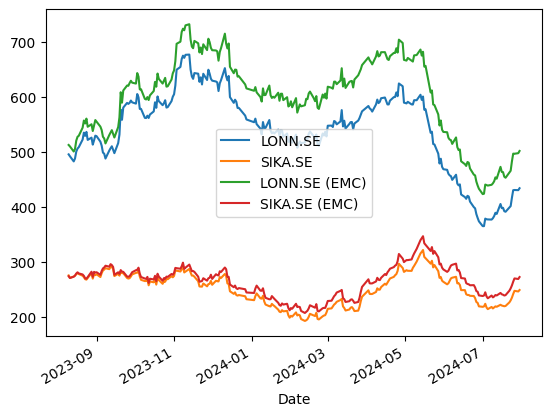

In [53]:
pd.concat([sim,sim_arr_EMC[0]],axis=1)

In [64]:
sim = sim.rename(columns={'LONN.SE': 'LONN.SE (MC)', 'SIKA.SE': 'SIKA.SE (MC)'})

In [70]:
df = pd.concat([data.loc['2023-07-01':],sim,sim_arr_EMC[0]], axis=1)

<Axes: title={'center': 'Martingale Correction Given S(0) On 2023-08-09'}, xlabel='Date'>

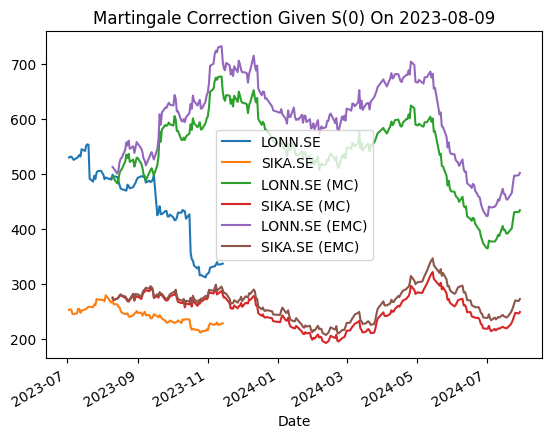

In [74]:
df.plot(title='Martingale Correction Given S(0) On 2023-08-09')

In [ ]:
payoffs_EMC = po.pricing_multiple(sim_arr_EMC)
